<center><h2> Subsurface acoustics from biogeochemical floats as a pathway to scalable autonomous observations of global surface wind </h2></center>
    
<center><h3> Analysis and figures </h3></center>

**L. Delaigue<sup>1</sup>\, P. Cauchy<sup>2</sup>, D. Cazau<sup>3</sup>, R. Bozzano<sup>4</sup>, S. Pensieri<sup>4</sup>, A. Gros-Martial<sup>5</sup>, J. Bonnel<sup>6</sup>, E. Leymarie<sup>1</sup> and H. Claustre<sup>1</sup>**

<sup>1</sup>Sorbonne Université, CNRS, Laboratoire d'Océanographie de Villefranche, LOV, 06230 Villefranche-sur-Mer, France

<sup>2</sup>Institut des sciences de la mer (ISMER), Université du Québec à Rimouski (UQAR), Rimouski, Canada

<sup>3</sup>ENSTA, Lab-STICC, UMR CNRS 6285, Brest, France

<sup>4</sup>Institute for the Study of Anthropic Impact and Sustainability in the Marine Environment (IAS), Consiglio Nazionale delle Ricerche (CNR), Genoa, Italy

<sup>5</sup>Centre d’Études Biologiques de Chizé, CNRS, Villiers-en-bois, France

<sup>6</sup>Marine Physical Laboratory, Scripps Institution of Oceanography, University of California San Diego, La Jolla, CA, 92093, USA


## Abstract

Wind forcing plays a pivotal role in driving upper-ocean physical and biogeochemical processes, yet direct wind observations remain sparse in many regions of the global ocean. While passive acoustic techniques have been used to estimate wind speed from moored and mobile platforms, their application to profiling floats has been demonstrated only in limited cases and remains largely unexplored. Here, we report on the first deployment of a Biogeochemical-Argo (BGC-Argo) float equipped with a passive acoustic sensor, aimed at detecting wind-driven surface signals from depth. The float was deployed in the northwestern Mediterranean Sea near the DYFAMED meteorological buoy from February to April 2025, operating at parking depths of 500–1000 m. We demonstrate that wind speed can be successfully retrieved from subsurface ambient noise using established acoustic algorithms, with float-derived estimates showing good agreement with collocated surface observations from the DYFAMED buoy. To evaluate the potential for broader application, we simulate a remote deployment scenario by refitting the acoustic model of Nystuen et al. (2015) using ERA5 reanalysis as a proxy for surface wind. Refitting the model to ERA5 data demonstrates that the float–acoustic–wind relationship is generalizable in moderate conditions, but high-wind regimes remain systematically biased—especially above 10 m s-1. Finally, we apply a residual learning framework to correct these estimates using a limited subset of DYFAMED wind data, simulating conditions where only brief surface observations—such as those from a ship during float deployment—are available. The corrected wind time series achieved a 37% reduction in RMSE and improved the coefficient of determination (R2) from 0.85 to 0.91, demonstrating the effectiveness of combining reanalysis with sparse in situ fitting. This framework enables the retrieval of fine-scale wind variability not captured by reanalysis alone, supporting a scalable strategy for float-based wind monitoring in data-sparse ocean regions—with important implications for quantifying air–sea exchanges, improving biogeochemical flux estimates, and advancing global climate observations.

## What to expect from this notebook?

#### This notebook provides a complete walkthrough of the data processing and analysis workflows used in this study. It includes code for preprocessing float and reference datasets, computing acoustic metrics, applying and refitting empirical wind retrieval models, evaluating performance against in situ and reanalysis wind products, and generating all associated figures and metrics reported in the paper.

____________

## Import libraries

In [1]:
# --- Standard Library ---
import glob
import os
import re
import string
from datetime import datetime, timedelta

# --- Core Scientific Libraries ---
import numpy as np
import pandas as pd
import xarray as xr

# --- Scientific Tools ---
from pyproj import Geod
from scipy import stats
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.stats import linregress
from shapely.geometry import Point
from shapely.ops import transform

# --- Visualization ---
import cmocean
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Progress Bar ---
from tqdm import tqdm

# --- Geospatial Distance ---
from geopy.distance import geodesic
from haversine import haversine, Unit

# --- Machine Learning ---
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')

## 1 - Process raw float data

Matching SBE41 and PAL data to DO dataset with 3-hour rolling mean...


100%|████████████████████████████████████| 12628/12628 [00:20<00:00, 619.17it/s]


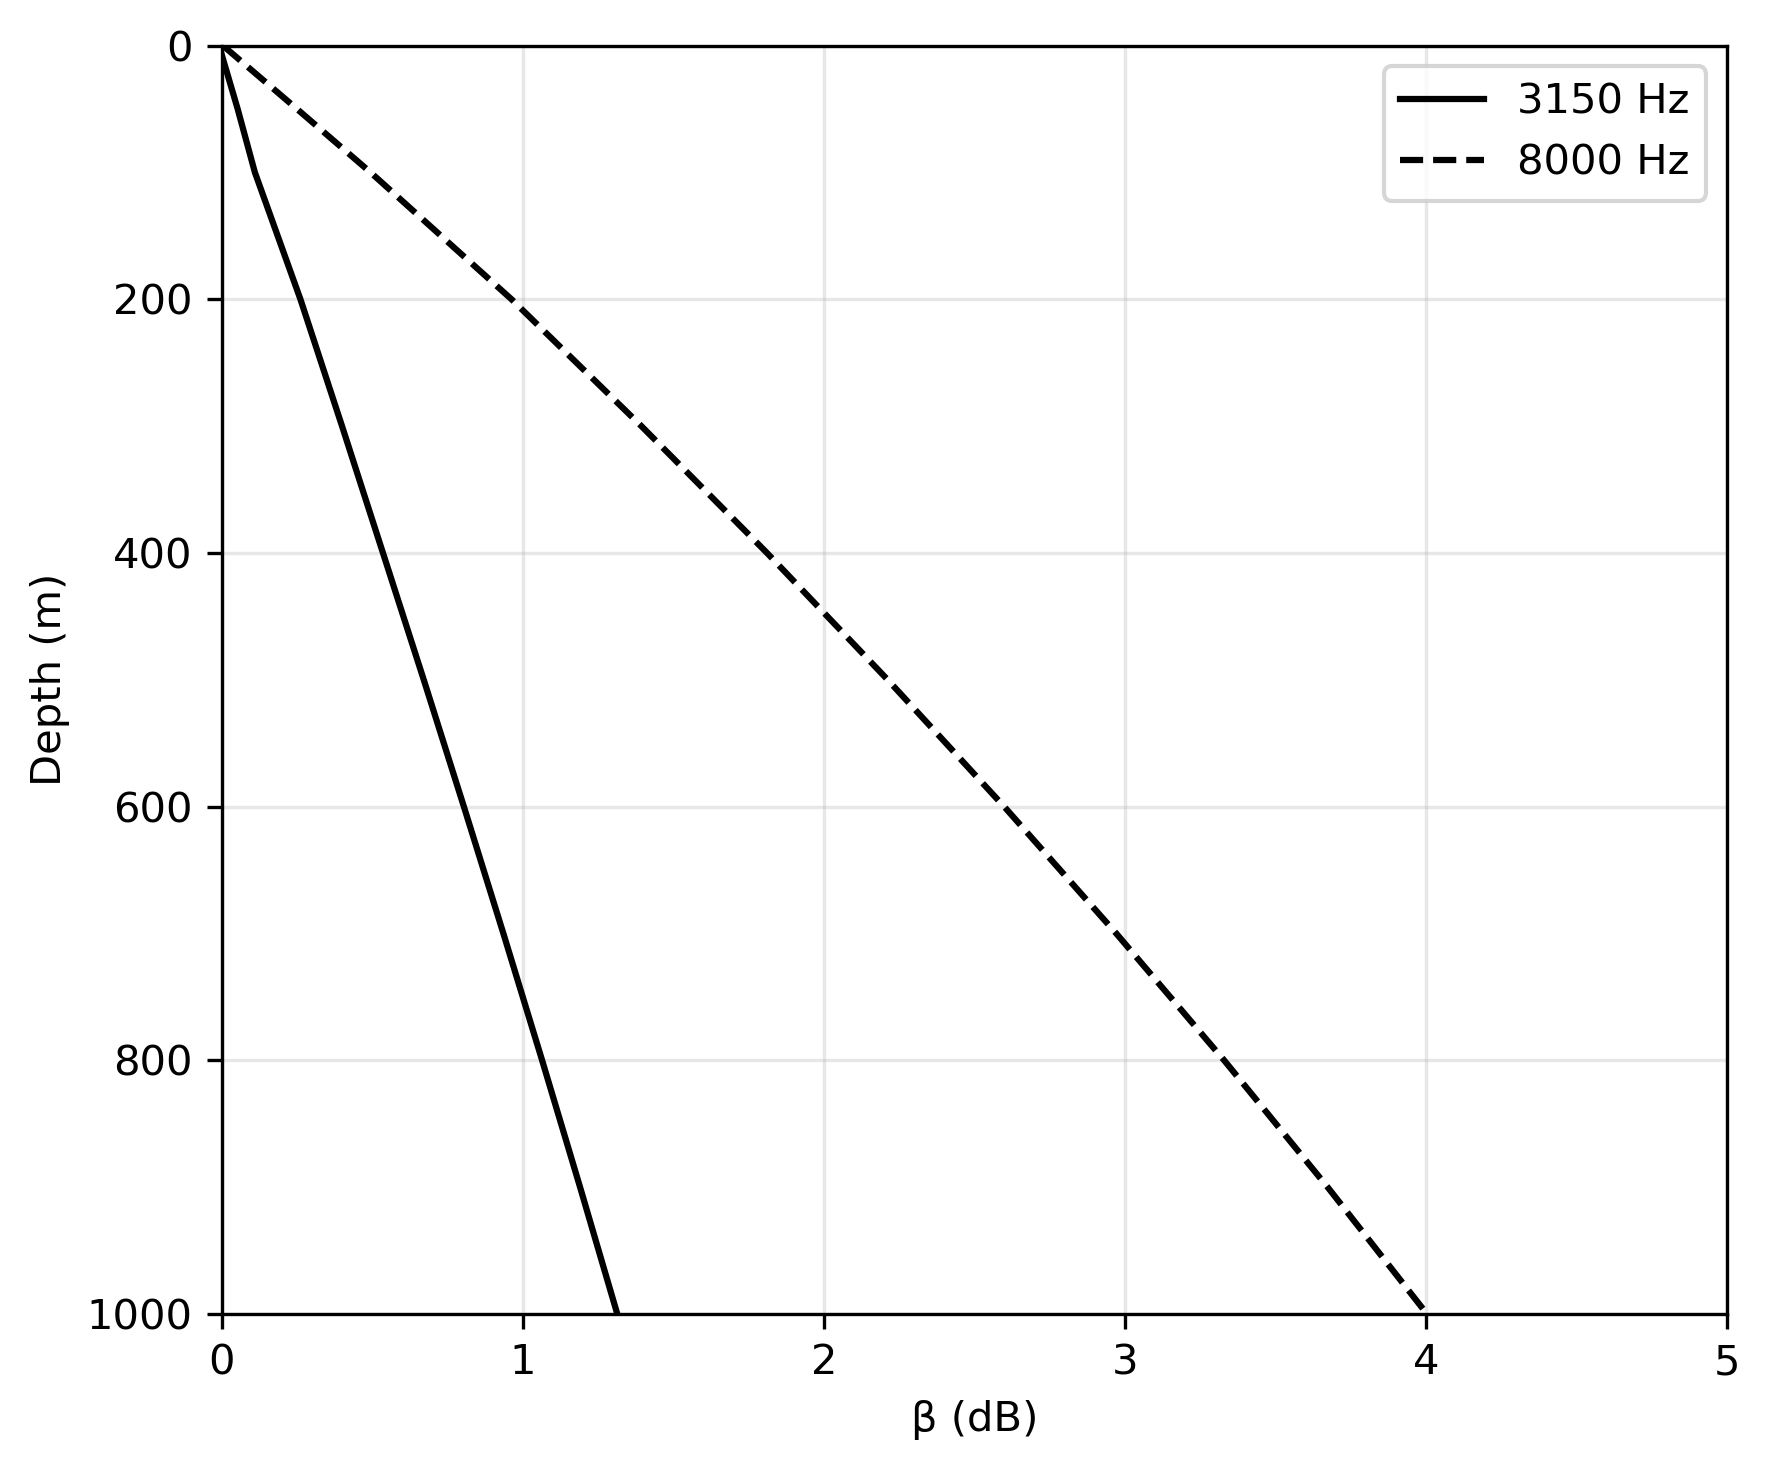

Merged data saved successfully. SPL values in dB re 1 µPa²/Hz with depth and frequency corrections applied.


In [2]:
# Define the path pattern for all matching files
file_pattern = "data/float/csv/lovuse024c_*.csv"

# Find all matching CSV files
csv_files = glob.glob(file_pattern)

# Define coordinate mapping (station_number -> (latitude, longitude))
coordinate_map = {
    # First deployment
    "040": (43.698656, 7.308651),
    "041": (43.395203, 7.867331),
    "042": (43.385816, 7.835610),
    "043": (43.383342, 7.805394),
    "044": (43.374554, 7.780598),
    "045": (43.347018, 7.761803),
    "046": (43.318718, 7.743787),
    "047": (43.306527, 7.715931),
    "048": (43.293565, 7.683848),
    "049": (43.271333, 7.634016),
    "050": (43.250653, 7.578438),
    "051": (43.237131, 7.537831),
    "052": (43.221096, 7.488428),
    "053": (43.181266, 7.432160),
    "054": (43.143442, 7.408066),
    "055": (43.113340, 7.377611),
    "056": (43.094762, 7.322352),
    "057": (43.080311, 7.263309),
    
    # Second deployment
    "058": (43.417590, 7.798665),  
    "059": (43.387746, 7.777208),
    "060": (43.363777, 7.730860),
    "061": (43.342675, 7.640585),
    "062": (43.313547, 7.565492),
    "063": (43.266750, 7.461486),
    "064": (43.240656, 7.400188),
    "065": (43.222551, 7.300435),
    "066": (43.208608, 7.130404),
    "067": (43.173637, 6.977106),
    "068": (43.167145, 6.954846),
    "069": (43.173564, 6.957003)
}

# List to store DataFrames
float_data_list = []

# Process each file
for file in csv_files:
    # Extract station number from filename
    match = re.search(r'lovuse024c_(\d{3})_', file)
    if match:
        station_number = match.group(1)  # Extract station number
        if station_number in coordinate_map:
            lat, lon = coordinate_map[station_number]

            # Load CSV file
            df = pd.read_csv(file, sep=",")
            
            # Add latitude, longitude, and station number columns
            df["Latitude"] = lat
            df["Longitude"] = lon
            df["StationNumber"] = station_number
            
            # Store in list
            float_data_list.append(df)

# Combine all files into one DataFrame
float_data = pd.concat(float_data_list, ignore_index=True)

# Convert Date column to datetime
float_data["Date"] = pd.to_datetime(float_data["Date"])

# Separate data based on SensorType
sbe41_data = float_data[float_data["SensorType"] == "sbe41"].copy()
pal_data = float_data[float_data["SensorType"] == "pal"].copy()
do_data = float_data[float_data["SensorType"] == "do"].copy()

# Convert Date to matplotlib float format for KDTree
sbe41_data["datenum"] = sbe41_data["Date"].map(mdates.date2num)
pal_data["datenum"] = pal_data["Date"].map(mdates.date2num)
do_data["datenum"] = do_data["Date"].map(mdates.date2num)

# Ensure Pressure is numeric
sbe41_data["Pressure_dbar"] = pd.to_numeric(sbe41_data["Pressure_dbar"], errors="coerce")
pal_data["Pressure_dbar"] = pd.to_numeric(pal_data["Pressure_dbar"], errors="coerce")
do_data["Pressure_dbar"] = pd.to_numeric(do_data["Pressure_dbar"], errors="coerce")

# DO remains the base dataset (7328 rows)
final_data = do_data.copy()

# Prepare empty lists for the new matched columns
sbe41_matched_cols = {col: [] for col in sbe41_data.columns if col not in ["datenum", "Pressure_dbar", "PhaseName", "SensorType"]}
# Only keep f_3150Hz and f_8000Hz in PAL matching
pal_f_keep = ["f_3150Hz", "f_8000Hz"]
pal_matched_cols = {col: [] for col in pal_data.columns if col in pal_f_keep or col in ["Date"]}

# Normalization by bandwidth to get SPL in dB re 1 µPa²/Hz from Abysens
frequency_correction = {
    "f_3150Hz": -28.66,
    "f_8000Hz": -32.68,
}

# Initialize a list to store matched PAL timestamps
matched_pal_dates = []

# Iterate over each row in DO and find the nearest match in SBE41 & PAL
print("Matching SBE41 and PAL data to DO dataset with 3-hour rolling mean...")

for _, do_row in tqdm(do_data.iterrows(), total=len(do_data)):
    phase = do_row["PhaseName"]
    date_pressure = np.array([[do_row["datenum"], do_row["Pressure_dbar"]]])

    # Find nearest SBE41 match (same PhaseName + nearest Date + nearest Pressure)
    if not sbe41_data.empty and phase in sbe41_data["PhaseName"].unique():
        sbe41_phase = sbe41_data[sbe41_data["PhaseName"] == phase]
        if not sbe41_phase.empty:
            tree_sbe41 = cKDTree(sbe41_phase[["datenum", "Pressure_dbar"]].values)
            _, idx_sbe41 = tree_sbe41.query(date_pressure)
            matched_sbe41 = sbe41_phase.iloc[idx_sbe41[0]]
        else:
            matched_sbe41 = pd.Series(index=sbe41_data.columns, dtype="float64")  # Empty row
    else:
        matched_sbe41 = pd.Series(index=sbe41_data.columns, dtype="float64")  # Empty row

    # Find nearest PAL match (same PhaseName + nearest Date + nearest Pressure)
    if not pal_data.empty and phase in pal_data["PhaseName"].unique():
        pal_phase = pal_data[pal_data["PhaseName"] == phase]
        if not pal_phase.empty:
            tree_pal = cKDTree(pal_phase[["datenum", "Pressure_dbar"]].values)
            _, idx_pal = tree_pal.query(date_pressure)
            matched_pal = pal_phase.iloc[idx_pal[0]]  # Initial match
            
            # Store the timestamp before averaging
            matched_pal_dates.append(matched_pal["Date"])

            # Define the rolling window: ±1.5 hours
            time_window_start = matched_pal["Date"] - timedelta(hours=1.5)
            time_window_end = matched_pal["Date"] + timedelta(hours=1.5)

            # Select PAL rows within this time window
            pal_subset = pal_phase[
                (pal_phase["Date"] >= time_window_start) & 
                (pal_phase["Date"] <= time_window_end)
            ].copy()

            # Identify all f_* columns dynamically but keep only the two
            f_columns = [col for col in pal_subset.columns if col in pal_f_keep]

            # Apply NO correction yet! We do this later.
            # Flag PAL values above the 95th percentile before averaging
            for f_col in f_columns:
                threshold = pal_subset[f_col].quantile(0.95)
                pal_subset.loc[pal_subset[f_col] > threshold, f_col] = np.nan

            # Compute mean for numeric columns after flagging
            if not pal_subset.empty:
                matched_pal_mean = pal_subset.mean(numeric_only=True)
                # Make sure all requested keys exist (else will be nan)
                matched_pal = pd.Series({col: matched_pal_mean.get(col, np.nan) for col in pal_f_keep})
                matched_pal["Date"] = matched_pal_dates[-1]
            else:
                matched_pal = pd.Series({col: np.nan for col in pal_f_keep + ["Date"]})
            
        else:
            matched_pal = pd.Series({col: np.nan for col in pal_f_keep + ["Date"]})
            matched_pal_dates.append(np.nan)  # Ensure we store NaN if no match found
    else:
        matched_pal = pd.Series({col: np.nan for col in pal_f_keep + ["Date"]})
        matched_pal_dates.append(np.nan)  # Store NaN for missing timestamps

    # Append matched data
    for col in sbe41_matched_cols:
        sbe41_matched_cols[col].append(matched_sbe41.get(col, np.nan))

    for col in pal_matched_cols:
        pal_matched_cols[col].append(matched_pal.get(col, np.nan))

# Add matched SBE41 columns to the final DataFrame
for col, values in sbe41_matched_cols.items():
    final_data[col + "_sbe41"] = values

# Add matched PAL columns to the final DataFrame
for col, values in pal_matched_cols.items():
    if col == "Date":
        final_data["datetime_pal"] = values
    else:
        final_data[col + "_pal"] = values

# Convert datetime_pal to datetime format
final_data["datetime_pal"] = pd.to_datetime(final_data["datetime_pal"], errors="coerce")

# Final check: Ensure DO row count remains the same as base
assert len(final_data) == len(do_data), f"Error: Final dataset has {len(final_data)} rows instead of {len(do_data)}!"

# Only keep f_3150Hz_pal and f_8000Hz_pal columns from PAL (plus the others you specify)
pal_f_columns = ["f_3150Hz_pal", "f_8000Hz_pal"]

# Define the list of other columns to keep
cols_to_keep = [
    "StationNumber",  # Include station number
    "Latitude",
    "Longitude",
    "Pressure_dbar",
    "Date",
    "PhaseName",
    "doxy_uncalibrated",
    "datenum",
    "Date_sbe41",
    "Temperature_degC_sbe41",
    "Salinity_PSU_sbe41",
    "datetime_pal",
] + pal_f_columns  # Only the two PAL f_ columns

# Keep only the selected columns
final_data = final_data[cols_to_keep]

# Update renaming dictionary
rename_dict = {
    "StationNumber": "station_number",  # Rename station number
    "Latitude":"latitude",
    "Longitude":"longitude",
    "Pressure_dbar": "pressure",
    "Date": "datetime_DO",
    "PhaseName": "phasename",
    "doxy_uncalibrated": "doxy",
    "datenum": "datenum",
    "Date_sbe41": "datetime_SBE41",
    "Temperature_degC_sbe41": "temperature",
    "Salinity_PSU_sbe41": "salinity",
    "f_3150Hz_pal": "f_3150Hz",
    "f_8000Hz_pal": "f_8000Hz",
}

float_data = final_data.rename(columns=rename_dict)
del final_data

# Converting 'datetime_DO' to datetime format if it's not already
float_data['datetime_DO'] = pd.to_datetime(float_data['datetime_DO'], errors='coerce')

# final_data new columns for year, month, and day
float_data['year'] = float_data['datetime_DO'].dt.year
float_data['month'] = float_data['datetime_DO'].dt.month
float_data['day'] = float_data['datetime_DO'].dt.day

# Convert datetime to numerical format for plotting later
float_data["datenum"] = mdates.date2num(float_data["datetime_DO"])

# Ensuite station number remains
float_data["station_number"] = float_data["station_number"].astype(str)  # Ensure it's treated as a string

# --------------- BEGIN BETA/DEPTH CORRECTION THEN APPLY FREQ CORRECTION ---------------

# Load beta values from MATLAB run
beta_df = pd.read_csv("data/beta_profile_output.csv")

# Convert complex strings to Python complex numbers and extract real part
beta_df['Beta_dB_f3150'] = beta_df['Beta_dB_f3150'].apply(lambda x: complex(str(x).replace('i', 'j'))).apply(np.real)
beta_df['Beta_dB_f8000'] = beta_df['Beta_dB_f8000'].apply(lambda x: complex(str(x).replace('i', 'j'))).apply(np.real)

# Interpolate/extrapolate to 0 m using first two points
d1, d2 = beta_df['Depth_m'].iloc[0], beta_df['Depth_m'].iloc[1]
b1_3150, b2_3150 = beta_df['Beta_dB_f3150'].iloc[0], beta_df['Beta_dB_f3150'].iloc[1]
b1_8000, b2_8000 = beta_df['Beta_dB_f8000'].iloc[0], beta_df['Beta_dB_f8000'].iloc[1]

# Linear extrapolation to 0 m
beta_0_3150 = b1_3150 + (b1_3150 - b2_3150) / (d1 - d2) * (0 - d1)
beta_0_8000 = b1_8000 + (b1_8000 - b2_8000) / (d1 - d2) * (0 - d1)

# Insert new row at the top
beta_df_extended = pd.concat([
    pd.DataFrame({
        'Depth_m': [0],
        'Beta_dB_f3150': [beta_0_3150],
        'Beta_dB_f8000': [beta_0_8000]
    }),
    beta_df
], ignore_index=True)

# Plot using fig, ax
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
ax.plot(beta_df_extended['Beta_dB_f3150'], beta_df_extended['Depth_m'], c='k', label='3150 Hz')
ax.plot(beta_df_extended['Beta_dB_f8000'], beta_df_extended['Depth_m'], c='k', linestyle='--', label='8000 Hz')

# Customize plot
ax.set_xlabel('β (dB)')
ax.set_ylabel('Depth (m)')
ax.set_xlim(0, 5)
ax.set_ylim(0, 1000)
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig("figs/Figure_2.png", dpi=300, bbox_inches='tight')
plt.show()

# Create interpolation functions (with extrapolation enabled)
interp_3150 = interp1d(beta_df["Depth_m"], beta_df["Beta_dB_f3150"], bounds_error=False, fill_value="extrapolate")
interp_8000 = interp1d(beta_df["Depth_m"], beta_df["Beta_dB_f8000"], bounds_error=False, fill_value="extrapolate")

# Interpolate beta for each row based on pressure
float_data["beta_f3150"] = interp_3150(float_data["pressure"])
float_data["beta_f8000"] = interp_8000(float_data["pressure"])

# Apply depth correction (i.e., add beta)
float_data["f_3150Hz_beta"] = float_data["f_3150Hz"] + float_data["beta_f3150"]
float_data["f_8000Hz_beta"] = float_data["f_8000Hz"] + float_data["beta_f8000"]

# Now apply frequency correction (to the depth-corrected values)
float_data["f_3150Hz_corrected"] = float_data["f_3150Hz_beta"] + frequency_correction["f_3150Hz"]
float_data["f_8000Hz_corrected"] = float_data["f_8000Hz_beta"] + frequency_correction["f_8000Hz"]

print("Merged data saved successfully. SPL values in dB re 1 µPa²/Hz with depth and frequency corrections applied.")


## 2 - Plot deployment trajectory

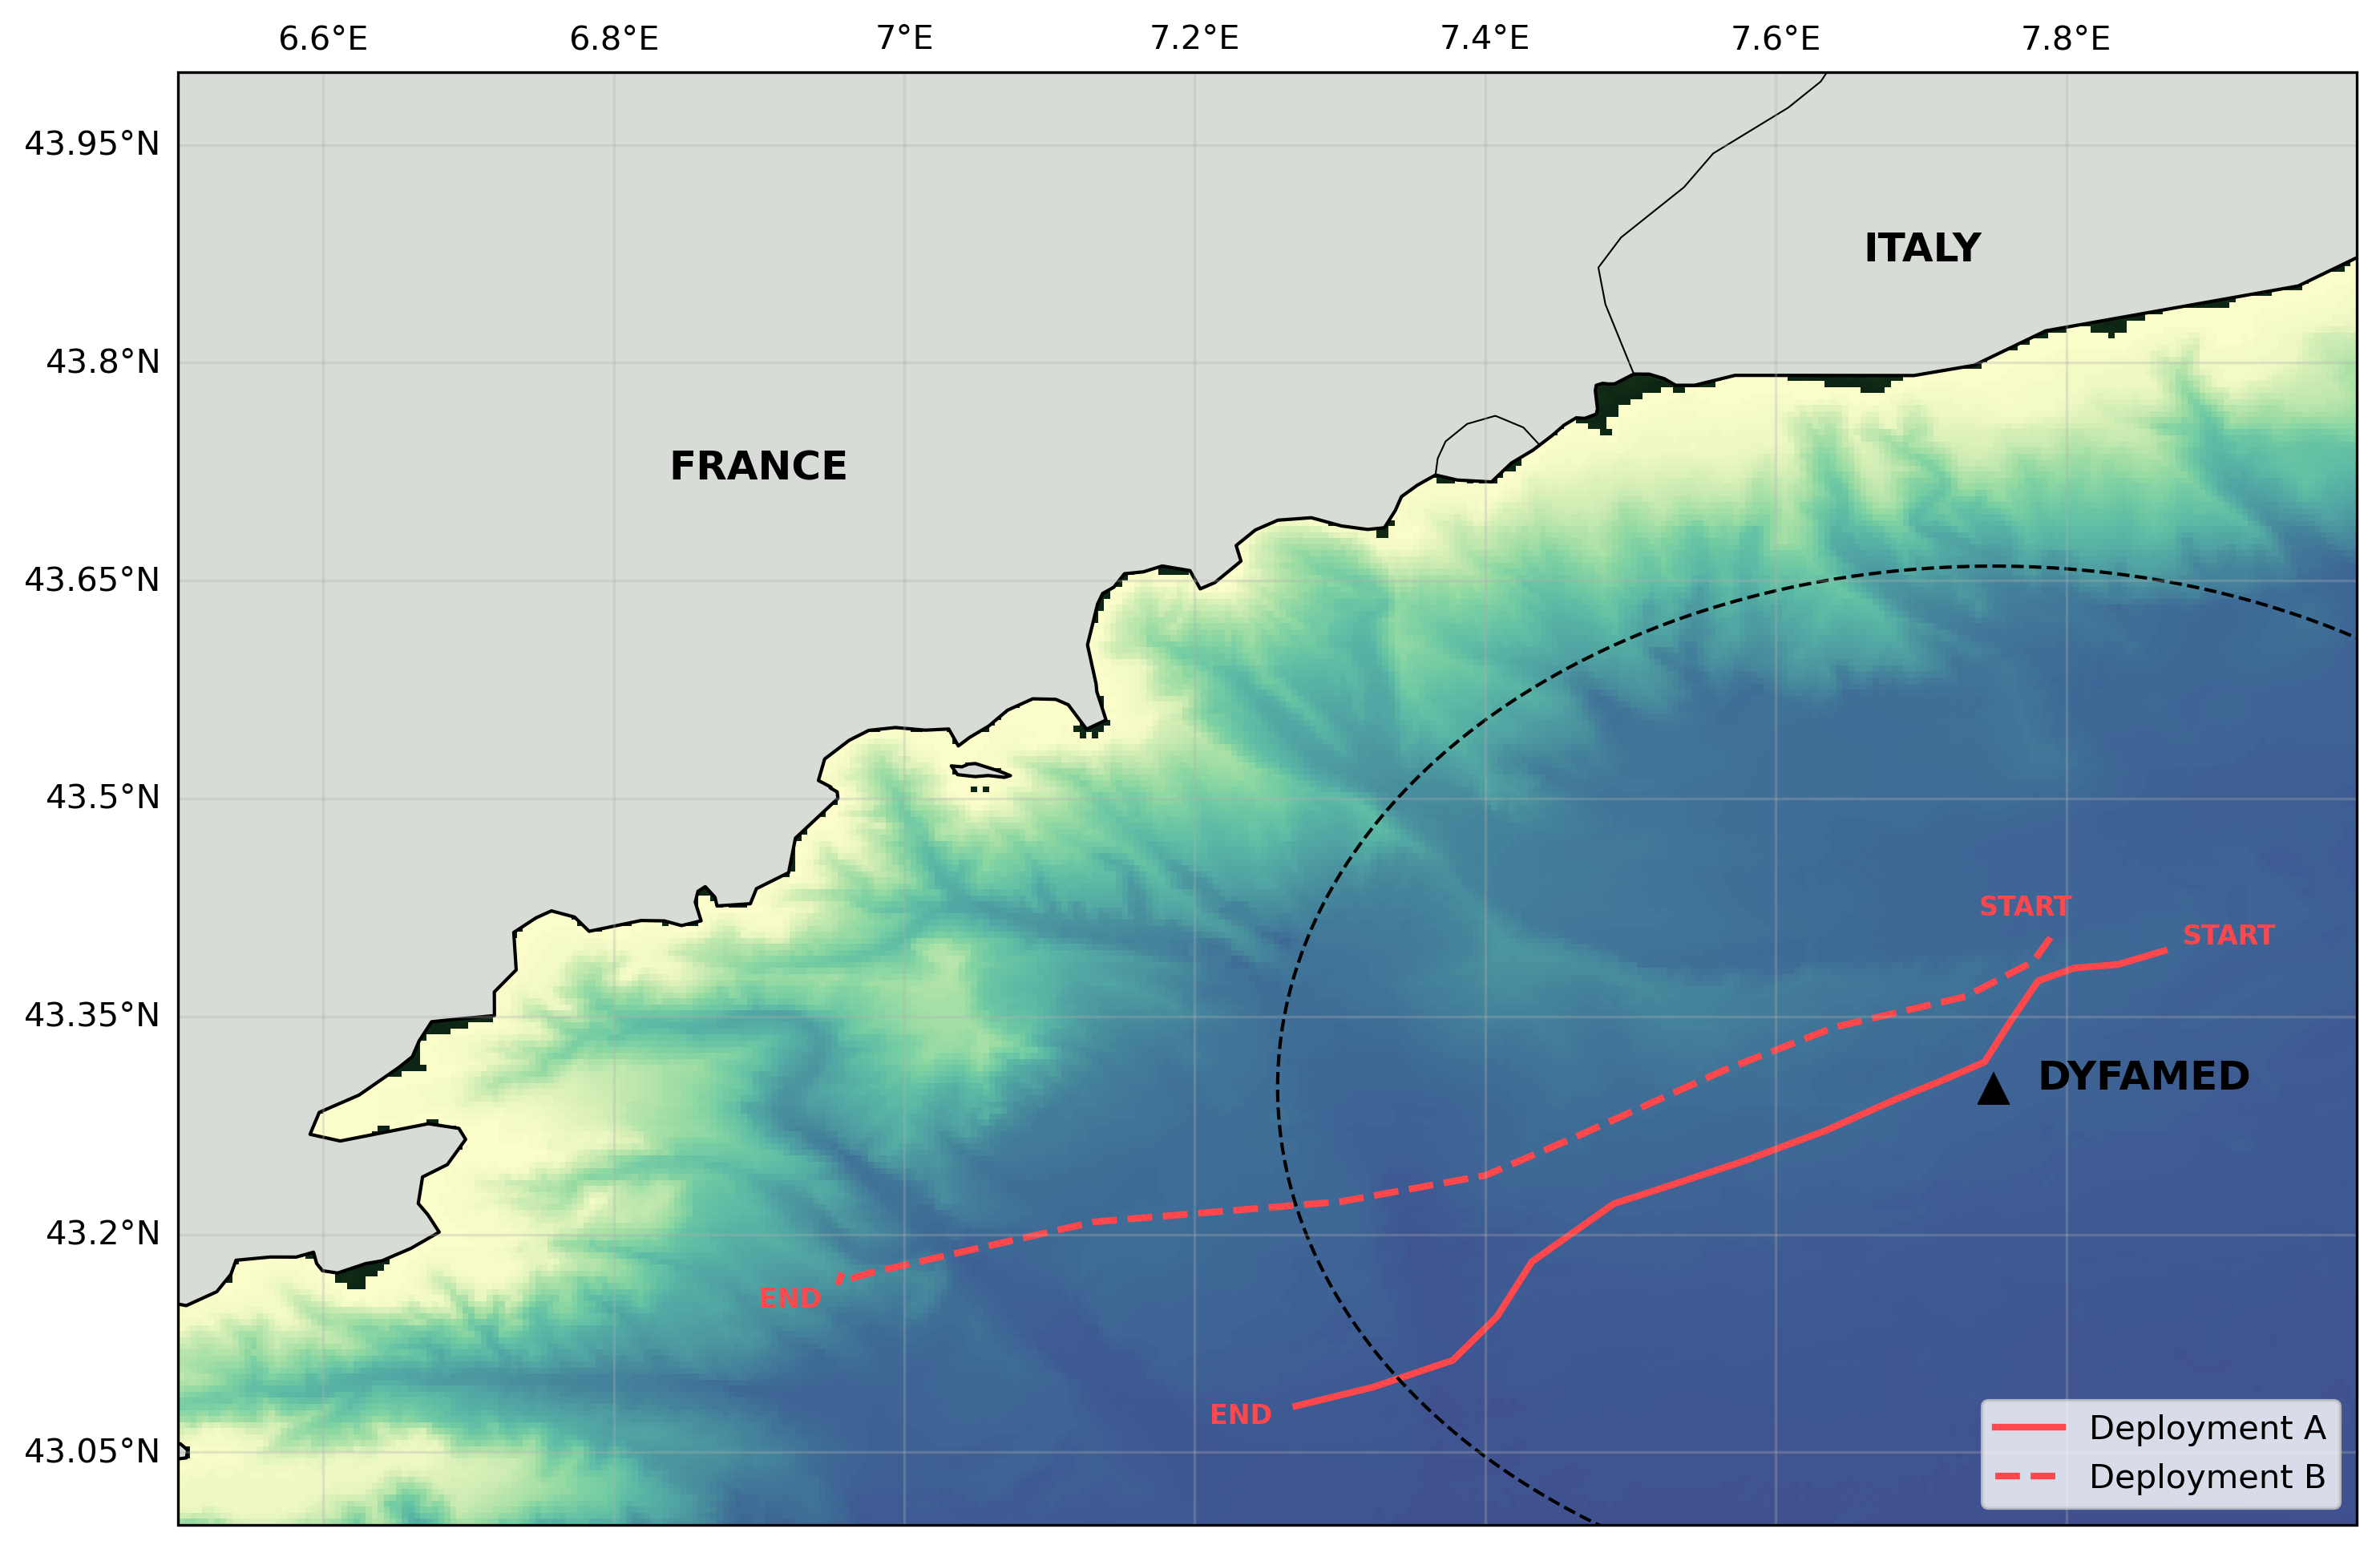

In [3]:
# Copy input data
df = float_data.copy()

# Prepare station data
stations_df = (
    df[["station_number", "latitude", "longitude", "datetime_DO"]]
    .drop_duplicates(subset=["station_number", "latitude", "longitude"])
    .sort_values("station_number")
    .reset_index(drop=True)
)

stations_df["datetime_DO"] = pd.to_datetime(stations_df["datetime_DO"])
stations_df = stations_df.sort_values("datetime_DO").reset_index(drop=True)

#  Interpolate trajectory 
geod = Geod(ellps="WGS84")
interpolated_rows = []

for i in range(len(stations_df) - 1):
    start = stations_df.iloc[i]
    end = stations_df.iloc[i + 1]

    start_time = start["datetime_DO"]
    end_time = end["datetime_DO"]
    duration_hours = int((end_time - start_time).total_seconds() // 3600)

    if duration_hours <= 0:
        continue

    # Intermediate points between stations
    lonlats = geod.npts(
        start["longitude"], start["latitude"],
        end["longitude"], end["latitude"],
        duration_hours - 1
    )

    # Add start point
    interpolated_rows.append({
        "datetime": start_time,
        "latitude": start["latitude"],
        "longitude": start["longitude"]
    })

    # Add interpolated points
    for j, (lon, lat) in enumerate(lonlats):
        interpolated_rows.append({
            "datetime": start_time + timedelta(hours=j + 1),
            "latitude": lat,
            "longitude": lon
        })

# Add final point
interpolated_rows.append({
    "datetime": stations_df.iloc[-1]["datetime_DO"],
    "latitude": stations_df.iloc[-1]["latitude"],
    "longitude": stations_df.iloc[-1]["longitude"]
})

trajectory_df = pd.DataFrame(interpolated_rows)
trajectory_df["datetime"] = pd.to_datetime(trajectory_df["datetime"])

#  Filter out unwanted time window 
trajectory_df = trajectory_df[
    ~trajectory_df["datetime"].between("2025-03-10 08:00:00", "2025-03-13 06:00:00")
].reset_index(drop=True)

#  Load bathymetry data 
bathymetry = xr.open_dataset(
    "data/GEBCO_21_Mar_2025_ecf26466cdc0/GEBCO_21_Mar_2025_ecf26466cdc0/gebco_2024_n44.881_s41.153_w4.3652_e9.7485.nc"
)

#  Split deployments based on station 058 
deployment_boundary = float_data[float_data["station_number"] == "058"]["datenum"].min()
deployment_boundary_dt = mdates.num2date(deployment_boundary).replace(tzinfo=None)

deployment_1 = trajectory_df[trajectory_df["datetime"] < deployment_boundary_dt]
deployment_2 = trajectory_df[trajectory_df["datetime"] >= deployment_boundary_dt]

#  Plot setup 
fig = plt.figure(dpi=300, figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Base map
ax.add_feature(
    cfeature.NaturalEarthFeature("physical", "land", "10m"),
    facecolor="xkcd:light grey", edgecolor="k"
)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="k")

# Bathymetry
bathymetry.elevation.plot(
    add_colorbar=False,
    ax=ax,
    cmap=cmocean.cm.topo,
    transform=ccrs.PlateCarree(),
    zorder=0
)

# Deployment paths
ax.plot(
    deployment_1["longitude"], deployment_1["latitude"],
    color="xkcd:light red", linestyle="solid", linewidth=2,
    transform=ccrs.PlateCarree(), label="Deployment A"
)

ax.plot(
    deployment_2["longitude"], deployment_2["latitude"],
    color="xkcd:light red", linestyle="dashed", linewidth=2,
    transform=ccrs.PlateCarree(), label="Deployment B"
)

# Text annotations
ax.plot(7.75, 43.3, marker='^', color='k', markersize=8, transform=ccrs.PlateCarree())
ax.text(7.78, 43.3, "DYFAMED", transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold')

ax.text(6.838, 43.72, "FRANCE", transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold')
ax.text(7.66, 43.87, "ITALY", transform=ccrs.PlateCarree(), fontsize=12, fontweight='bold')

ax.text(7.74, 43.42, "START", transform=ccrs.PlateCarree(), fontsize=8, fontweight='bold', color='xkcd:light red')
ax.text(6.90, 43.15, "END", transform=ccrs.PlateCarree(), fontsize=8, fontweight='bold', color='xkcd:light red')

ax.text(7.88, 43.4, "START", transform=ccrs.PlateCarree(), fontsize=8, fontweight='bold', color='xkcd:light red')
ax.text(7.21, 43.07, "END", transform=ccrs.PlateCarree(), fontsize=8, fontweight='bold', color='xkcd:light red')

# Concentric circle (e.g., 40 km radius) around DYFAMED
dyfamed_lon, dyfamed_lat = 7.75, 43.3
radii_km = [40]

for radius in radii_km:
    angle = np.linspace(0, 360, 361)
    circle_lon, circle_lat, _ = geod.fwd(
        np.full_like(angle, dyfamed_lon),
        np.full_like(angle, dyfamed_lat),
        angle,
        np.full_like(angle, radius * 1000)  # in meters
    )
    ax.plot(circle_lon, circle_lat, linestyle="--", linewidth=1, color="black", transform=ccrs.PlateCarree())

# Map extent and grid
ax.set_extent([6.5, 8, 43, 44], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, alpha=0.3)
gl.bottom_labels = False
gl.right_labels = False

# Legend and save
ax.legend(loc="lower right")
plt.tight_layout()
fig.savefig("figs/Figure_1.png", dpi=300, bbox_inches="tight")
plt.show()


## 3 - Process DYFAMED meteorological data

In [4]:
# Load both months' data and combine
files = ["data/meteo_france_vent/marine.202502.csv", "data/meteo_france_vent/marine.202503.csv", "data/meteo_france_vent/marine.202504.csv"]
wind_data = pd.concat([pd.read_csv(f, sep=";", na_values='mq') for f in files], ignore_index=True)

# Only keep data for DYFAMED
wind_data = wind_data[wind_data['numer_sta'] == '6100001']

# Rename columns
wind_data = wind_data.rename(columns={
    "date": "datetime",
    "ff": "U_DYFAMED",
})[["datetime", "U_DYFAMED"]]

# Function to parse datetime in "YYYYMMDDHHMMSS" format
def parse_datetime(date_str):
    try:
        return datetime.strptime(str(date_str), "%Y%m%d%H%M%S")
    except Exception as e:
        print(f"Error parsing date: {date_str} - {e}")
        return np.nan  # Return NaN if parsing fails

# Apply datetime parsing
wind_data["datetime"] = wind_data["datetime"].apply(parse_datetime)

# Drop any rows where datetime parsing failed
wind_data = wind_data.dropna(subset=["datetime"])

# Convert datetime columns to datetime format
# float_data["Date"] = pd.to_datetime(float_data["Date"])
wind_data["datetime"] = pd.to_datetime(wind_data["datetime"])

# Ensure wind_data is sorted and has unique timestamps
wind_data = wind_data.sort_values("datetime").drop_duplicates(subset=["datetime"])

# Convert datetime to numerical format for plotting
wind_data["datenum"] = mdates.date2num(wind_data["datetime"])

# Add latitude and longitude
wind_data["lat"] = 43.38
wind_data["lon"] = 7.83

## 4 - Match DYFAMED wind to float data

In [5]:
# Convert datetime columns to datetime format
float_data = float_data.reset_index(drop=True)
float_data["datetime_DO"] = pd.to_datetime(float_data["datetime_DO"])
wind_data["datetime"] = pd.to_datetime(wind_data["datetime"])

# Ensure wind_data is sorted and has unique timestamps
wind_data = wind_data.sort_values("datetime").drop_duplicates(subset=["datetime"])

# Match with wind data using the nearest timestamp approach
matched_wind_data = wind_data.set_index("datetime").reindex(float_data["datetime_DO"], method="nearest").reset_index()

# Add matched wind speed directly to float_data
float_data["U_DYFAMED"] = matched_wind_data["U_DYFAMED"]

# Extract matched f_8000Hz and wind speed (after ensuring non-null values)
X_data = float_data["f_8000Hz"].dropna()
Y_data = float_data["U_DYFAMED"].dropna()

# Ensure both datasets align (remove unmatched indices)
common_indices = X_data.index.intersection(Y_data.index)
X_data = X_data.loc[common_indices]
Y_data = Y_data.loc[common_indices]

# Define DYFAMED buoy coordinates
buoy_lat, buoy_lon = wind_data["lat"].unique(), wind_data["lon"].unique()

# Ensure 'Latitude' and 'Longitude' exist and do not contain NaN values
if "latitude" in float_data.columns and "longitude" in float_data.columns:
    # Remove rows with NaN in Latitude or Longitude before applying distance function
    valid_data = float_data.dropna(subset=["latitude", "longitude"]).copy()

    # Apply geodesic distance calculation only for valid rows
    valid_data["distance_km"] = valid_data.apply(
        lambda row: geodesic((row["latitude"], row["longitude"]), (buoy_lat, buoy_lon)).km, axis=1
    )

    # Merge back with float_data (ensure NaN distances remain for missing coordinates)
    float_data = float_data.merge(valid_data[["datetime_DO", "distance_km"]], on="datetime_DO", how="left")

else:
    print("Error: 'latitude' and 'longitude' columns not found in float_data.")

# Normalize distances (only if distance_km exists and is valid)
if "distance_km" in float_data.columns:
    float_data["norm_distance"] = (float_data["distance_km"] - float_data["distance_km"].min()) / \
                                  (float_data["distance_km"].max() - float_data["distance_km"].min())

## 5 - Fit already-existing algorithms

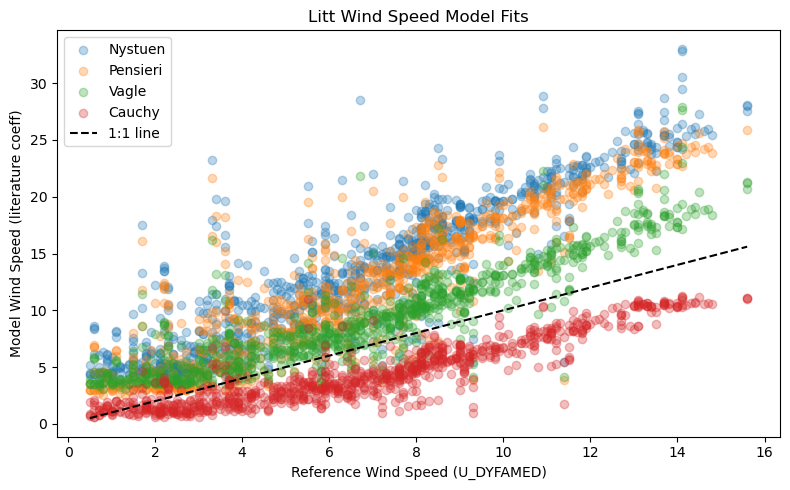

In [6]:
#  Wind Speed Model Functions 

def nystuen2015(SPL):
    return 0.0005 * SPL**3 - 0.0310 * SPL**2 + 0.4904 * SPL + 2.0871

def pensieri2015(SPL):
    SPL = np.asarray(SPL)
    result = np.full_like(SPL, np.nan, dtype=np.float64)
    mask1 = (SPL >= 30) & (SPL < 38)
    mask2 = (SPL >= 38) & (SPL < 60)
    result[mask1] = 0.1458 * SPL[mask1] - 3.146
    result[mask2] = 0.044642 * SPL[mask2]**2 - 3.2917 * SPL[mask2] + 63.016
    return result

def vagle1990(SPL):
    A = 7.38
    B = -38.70
    C = SPL - 21.69
    discriminant = B**2 - 4 * A * C
    result = np.full_like(SPL, np.nan, dtype=np.float64)
    mask = discriminant >= 0
    root_term = np.sqrt(discriminant[mask])
    exponent = (-B - root_term) / (2 * A)
    result[mask] = 10 ** exponent
    return result

def band_integration_coeff(fc):
    freq_min = fc * 2 ** (-1/6)
    freq_max = fc * 2 ** (1/6)
    return 10 * np.log10(freq_max - freq_min)

def cauchy2018_spl(SPL, S_off, coeff):
    SPL = np.asarray(SPL)
    TOL_equiv = SPL + coeff
    p = 10 ** (TOL_equiv / 20) - S_off
    # Model coefficients from paper
    s_low = 0.4e4
    b_low = 0.2e4
    s_high = 1.6e4
    b_high = 12.5e4
    U_low = (p + b_low) / s_low
    U_high = (p + b_high) / s_high
    return np.where(U_low > 10, U_high, U_low)

# Calculate Cauchy band integration coeff and S_off
fc = 3150
coeff = band_integration_coeff(fc)
S_off = np.nanmin(10 ** (float_data["f_3150Hz"]/20))

# Apply models 

# Nystuen and Vagle can be applied to all non-NaN SPLs
float_data["U_nystuen_litt_coeffs"] = nystuen2015(float_data["f_8000Hz_corrected"])
float_data["U_vagle_litt_coeffs"] = vagle1990(float_data["f_8000Hz_corrected"])

# Pensieri: set values only in valid range [30, 60), NaN elsewhere
SPL_8000 = float_data["f_8000Hz_corrected"].values
U_pensieri = np.full_like(SPL_8000, np.nan, dtype=np.float64)
mask_pensieri = (SPL_8000 >= 30) & (SPL_8000 < 60)
U_pensieri[mask_pensieri] = pensieri2015(SPL_8000[mask_pensieri])
float_data["U_pensieri_litt_coeffs"] = U_pensieri

# Cauchy: apply to all non-NaN SPLs at 3150 Hz
SPL_3150 = float_data["f_3150Hz_corrected"].values
mask_cauchy = ~np.isnan(SPL_3150)
U_cauchy = np.full_like(SPL_3150, np.nan, dtype=np.float64)
U_cauchy[mask_cauchy] = cauchy2018_spl(SPL_3150[mask_cauchy], S_off=S_off, coeff=coeff)
float_data["U_cauchy_litt_coefs"] = U_cauchy

#  Plot for quick validation 
plt.figure(figsize=(8,5))
plt.scatter(float_data["U_DYFAMED"], float_data["U_nystuen_litt_coeffs"], alpha=0.3, label="Nystuen")
plt.scatter(float_data["U_DYFAMED"], float_data["U_pensieri_litt_coeffs"], alpha=0.3, label="Pensieri")
plt.scatter(float_data["U_DYFAMED"], float_data["U_vagle_litt_coeffs"],    alpha=0.3, label="Vagle")
plt.scatter(float_data["U_DYFAMED"], float_data["U_cauchy_litt_coefs"],   alpha=0.3, label="Cauchy")
plt.plot(
    [float_data["U_DYFAMED"].min(), float_data["U_DYFAMED"].max()],
    [float_data["U_DYFAMED"].min(), float_data["U_DYFAMED"].max()],
    'k--', label="1:1 line"
)
plt.xlabel("Reference Wind Speed (U_DYFAMED)")
plt.ylabel("Model Wind Speed (literature coeff)")
plt.legend()
plt.title("Litt Wind Speed Model Fits")
plt.tight_layout()
plt.show()


## 6 - Optimize already-existing algorithms

Nystuen coefficients: [ 1.17174186e-03 -1.54309911e-01  7.17393779e+00 -1.13506379e+02]
Pensieri coefficients: [ 1.45800000e-01 -3.14600000e+00  2.28497272e-02 -1.67935526e+00
  3.26526371e+01]
Vagle coefficients: [ -6.04802928 -14.1475441   35.6110054 ]
Cauchy coefficients (s_low, b_low, s_high, b_high): [ 2934.70931245  5263.54061978  4356.64768452 16297.50533112]
Cauchy S_off (fixed): 2881.1032577843966 coeff (fixed): 28.629803404247166


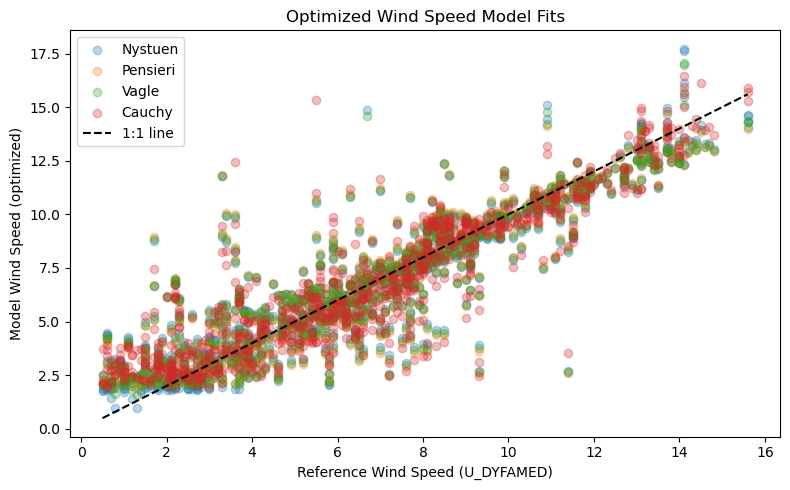

In [7]:
#  Wind Speed Model Functions 

def nystuen2015_fit(SPL, a, b, c, d):
    return a * SPL**3 + b * SPL**2 + c * SPL + d

def pensieri2015_fit(SPL, a1, b1, a2, b2, c2):
    SPL = np.asarray(SPL)
    result = np.full_like(SPL, np.nan, dtype=np.float64)
    mask1 = (SPL >= 30) & (SPL < 38)
    mask2 = (SPL >= 38) & (SPL < 60)
    result[mask1] = a1 * SPL[mask1] + b1
    result[mask2] = a2 * SPL[mask2]**2 + b2 * SPL[mask2] + c2
    return result

def vagle1990_fit(SPL, A, B, C0):
    SPL = np.asarray(SPL)
    C = SPL - C0
    discriminant = B**2 - 4 * A * C
    result = np.full_like(SPL, np.nan, dtype=np.float64)
    mask = discriminant >= 0
    root_term = np.sqrt(discriminant[mask])
    exponent = (-B - root_term) / (2 * A)
    result[mask] = 10 ** exponent
    return result

def cauchy2018_fit(SPL, S_off, coeff, s_low, b_low, s_high, b_high):
    SPL = np.asarray(SPL)
    TOL_equiv = SPL + coeff
    p = 10 ** (TOL_equiv / 20) - S_off
    U_low = (p + b_low) / s_low
    U_high = (p + b_high) / s_high
    return np.where(U_low > 10, U_high, U_low)

def band_integration_coeff(fc):
    freq_min = fc * 2 ** (-1/6)
    freq_max = fc * 2 ** (1/6)
    return 10 * np.log10(freq_max - freq_min)

#  Prepare data for each fit 

# Nystuen, Pensieri, Vagle use 8000 Hz
filt_8000 = (
    (float_data["distance_km"] < 40) &
    (~float_data["f_8000Hz_corrected"].isna()) &
    (~float_data["U_DYFAMED"].isna())
)
x_8000 = float_data.loc[filt_8000, "f_8000Hz_corrected"].values
y_8000 = float_data.loc[filt_8000, "U_DYFAMED"].values

# Cauchy uses 3150 Hz
filt_3150 = (
    (float_data["distance_km"] < 40) &
    (~float_data["f_3150Hz_corrected"].isna()) &
    (~float_data["U_DYFAMED"].isna())
)
x_3150 = float_data.loc[filt_3150, "f_3150Hz_corrected"].values
y_3150 = float_data.loc[filt_3150, "U_DYFAMED"].values

# Pensieri model is only defined for SPL in [30, 60)
pensieri_mask = (x_8000 >= 30) & (x_8000 < 60)
x_pensieri_fit = x_8000[pensieri_mask]
y_pensieri_fit = y_8000[pensieri_mask]

#  Initial parameter guesses 
nystuen_guess   = [0.0005, -0.0310, 0.4904, 2.0871]
pensieri_guess  = [0.1458, -3.146, 0.044642, -3.2917, 63.016]
vagle_guess     = [7.38, -38.70, 21.69]

fc = 3150
coeff_cauchy = band_integration_coeff(fc)
S_off_init = np.nanmin(10 ** (float_data["f_3150Hz"].dropna()/20))
cauchy_guess = [S_off_init, coeff_cauchy, 0.4e4, 0.2e4, 1.6e4, 12.5e4]

#  Curve fitting 

# Nystuen (fit to all filtered 8000Hz data)
popt_nystuen, _ = curve_fit(nystuen2015_fit, x_8000, y_8000, p0=nystuen_guess)

# Pensieri (fit only in [30, 60) SPL)
popt_pensieri, _ = curve_fit(pensieri2015_fit, x_pensieri_fit, y_pensieri_fit, p0=pensieri_guess)

# Vagle (fit to all filtered 8000Hz data)
popt_vagle, _ = curve_fit(vagle1990_fit, x_8000, y_8000, p0=vagle_guess)

# Cauchy (fit to all filtered 3150Hz data, but only free the last four params)
def cauchy2018_fit_partial(SPL, s_low, b_low, s_high, b_high):
    return cauchy2018_fit(SPL, S_off_init, coeff_cauchy, s_low, b_low, s_high, b_high)
popt_cauchy, _ = curve_fit(cauchy2018_fit_partial, x_3150, y_3150, p0=[0.4e4, 0.2e4, 1.6e4, 12.5e4])

#  Apply all models to the full dataset 

float_data["U_nystuen_opt_coeffs"] = nystuen2015_fit(float_data["f_8000Hz_corrected"].values, *popt_nystuen)
float_data["U_pensieri_opt_coeffs"] = pensieri2015_fit(float_data["f_8000Hz_corrected"].values, *popt_pensieri)
float_data["U_vagle_opt_coeffs"]    = vagle1990_fit(float_data["f_8000Hz_corrected"].values, *popt_vagle)
float_data["U_cauchy_opt_coeffs"]   = cauchy2018_fit(
    float_data["f_3150Hz_corrected"].values,
    S_off_init, coeff_cauchy, *popt_cauchy
)

#  Print fitted coefficients 

print("Nystuen coefficients:", popt_nystuen)
print("Pensieri coefficients:", popt_pensieri)
print("Vagle coefficients:", popt_vagle)
print("Cauchy coefficients (s_low, b_low, s_high, b_high):", popt_cauchy)
print("Cauchy S_off (fixed):", S_off_init, "coeff (fixed):", coeff_cauchy)

#  Plot for quick validation 

plt.figure(figsize=(8,5))
plt.scatter(float_data["U_DYFAMED"], float_data["U_nystuen_opt_coeffs"], alpha=0.3, label="Nystuen")
plt.scatter(float_data["U_DYFAMED"], float_data["U_pensieri_opt_coeffs"], alpha=0.3, label="Pensieri")
plt.scatter(float_data["U_DYFAMED"], float_data["U_vagle_opt_coeffs"],    alpha=0.3, label="Vagle")
plt.scatter(float_data["U_DYFAMED"], float_data["U_cauchy_opt_coeffs"],   alpha=0.3, label="Cauchy")
plt.plot(
    [float_data["U_DYFAMED"].min(), float_data["U_DYFAMED"].max()],
    [float_data["U_DYFAMED"].min(), float_data["U_DYFAMED"].max()],
    'k--', label="1:1 line"
)
plt.xlabel("Reference Wind Speed (U_DYFAMED)")
plt.ylabel("Model Wind Speed (optimized)")
plt.legend()
plt.title("Optimized Wind Speed Model Fits")
plt.tight_layout()
plt.show()


## 7 - Process AIS data

In [ ]:
# Parse datetime
float_data['datetime_DO'] = pd.to_datetime(float_data['datetime_DO'], errors='coerce')
float_data['nearby_ships'] = np.nan  # prefill with NaN

# Interpolate trajectory
df = float_data.copy()
geod = Geod(ellps="WGS84")

stations_df = (
    df[["station_number", "latitude", "longitude", "datetime_DO"]]
    .drop_duplicates(subset=["station_number", "latitude", "longitude"])
    .sort_values("datetime_DO")
    .reset_index(drop=True)
)
stations_df["datetime_DO"] = pd.to_datetime(stations_df["datetime_DO"])

interpolated_rows = []
for i in range(len(stations_df) - 1):
    start = stations_df.iloc[i]
    end = stations_df.iloc[i + 1]

    start_time = start["datetime_DO"]
    end_time = end["datetime_DO"]
    duration_hours = int((end_time - start_time).total_seconds() // 3600)

    if duration_hours <= 0:
        continue

    lonlats = geod.npts(
        start["longitude"], start["latitude"],
        end["longitude"], end["latitude"],
        duration_hours - 1
    )

    interpolated_rows.append({
        "datetime": start_time,
        "latitude_interp": start["latitude"],
        "longitude_interp": start["longitude"]
    })

    for j, (lon, lat) in enumerate(lonlats):
        interpolated_rows.append({
            "datetime": start_time + timedelta(hours=j + 1),
            "latitude_interp": lat,
            "longitude_interp": lon
        })

interpolated_rows.append({
    "datetime": stations_df.iloc[-1]["datetime_DO"],
    "latitude_interp": stations_df.iloc[-1]["latitude"],
    "longitude_interp": stations_df.iloc[-1]["longitude"]
})

interp_df = pd.DataFrame(interpolated_rows)
interp_df["datetime"] = pd.to_datetime(interp_df["datetime"])
float_data = float_data.sort_values("datetime_DO")
interp_df = interp_df.sort_values("datetime")

# Merge interpolated trajectory with float_data
float_data = pd.merge_asof(
    float_data,
    interp_df,
    left_on="datetime_DO",
    right_on="datetime",
    direction="nearest"
)

# Process AIS data
radius_km = 20
time_window_minutes = 30
data_folder = "data/AIS/parsed/"
bounding_box = (6.5, 8.0, 43.0, 44.0)

for filepath in glob.glob(os.path.join(data_folder, "ais_positions_*.csv")):
    print(f"Processing {filepath}")
    try:
        ais = pd.read_csv(filepath, on_bad_lines='skip', low_memory=False)
        ais = ais.dropna(subset=['utc_hour', 'utc_min', 'x', 'y'])

        west, east, south, north = bounding_box
        ais = ais[
            (ais['x'] >= west) & (ais['x'] <= east) &
            (ais['y'] >= south) & (ais['y'] <= north)
        ]

        ais['datetime'] = pd.to_datetime(dict(
            year=ais['file_year'].astype(int),
            month=ais['file_month'].astype(int),
            day=ais['file_day'].astype(int),
            hour=ais['utc_hour'].astype(int),
            minute=ais['utc_min'].astype(int)
        ), errors='coerce')

        if ais.empty:
            continue

        ais_date = ais['datetime'].dt.date.unique()[0]
        float_mask = float_data['datetime_DO'].dt.date == ais_date

        if not float_mask.any():
            continue

        float_subset = float_data[float_mask].copy()
        ship_counts = []

        for _, float_row in float_subset.iterrows():
            lat_f = float_row['latitude_interp']
            lon_f = float_row['longitude_interp']
            time_f = float_row['datetime_DO']

            if pd.isna(time_f) or pd.isna(lat_f) or pd.isna(lon_f):
                ship_counts.append(np.nan)
                continue

            start = time_f - pd.Timedelta(minutes=time_window_minutes)
            end = time_f + pd.Timedelta(minutes=time_window_minutes)

            ais_window = ais[(ais['datetime'] >= start) & (ais['datetime'] <= end)]
            ais_dedup = ais_window.sort_values('datetime').drop_duplicates(subset='mmsi', keep='first')

            distances = ais_dedup.apply(
                lambda row: haversine((lat_f, lon_f), (row['y'], row['x']), unit=Unit.KILOMETERS),
                axis=1
            )
            ship_counts.append((distances <= radius_km).sum())

        float_data.loc[float_mask, 'nearby_ships'] = ship_counts

    except Exception as e:
        print(f"Error in {filepath}: {e}")
        continue

# Highlighting and plotting deviations
float_data['U_diff'] = float_data['U_nystuen_opt_coeffs'] - float_data['U_DYFAMED']
float_data['datetime'] = pd.to_datetime(float_data['datetime'])
float_data = float_data.sort_values('datetime')
rmse = (float_data['U_diff']**2).mean()**0.5

ship_times = float_data[float_data['nearby_ships'] > 0]['datetime']

def highlight_condition(dt, diff):
    is_significant = abs(diff) > rmse
    is_ship_nearby = any(abs((dt - ship_time).total_seconds()) <= 1800 for ship_time in ship_times)
    return is_significant and is_ship_nearby

float_data['highlight'] = float_data.apply(
    lambda row: highlight_condition(row['datetime'], row['U_diff']), axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
current_color = None
segment_x, segment_y = [], []

for idx, row in float_data.iterrows():
    color = 'red' if row['highlight'] else 'tab:blue'
    if current_color is None:
        current_color = color

    if color != current_color and segment_x:
        ax.plot(segment_x, segment_y, color=current_color)
        segment_x, segment_y = [], []
        current_color = color

    segment_x.append(row['datetime'])
    segment_y.append(row['U_diff'])

if segment_x:
    ax.plot(segment_x, segment_y, color=current_color)

ax.set_xlabel('Time')
ax.set_ylabel('U Difference (m/s)')
ax.set_title(f'Deviation U Float - U DYFAMED (Red = |Diff| > RMSE ≈ {rmse:.2f} & Ship Nearby)')
ax.grid(True)
plt.tight_layout()
plt.show()

# Step 6: remove suspect data
float_data = float_data[~float_data['highlight']]


Processing data/AIS/parsed/ais_positions_20250316.csv
Processing data/AIS/parsed/ais_positions_20250302.csv
Processing data/AIS/parsed/ais_positions_20250303.csv
Processing data/AIS/parsed/ais_positions_20250317.csv
Processing data/AIS/parsed/ais_positions_20250301.csv
Processing data/AIS/parsed/ais_positions_20250315.csv
Processing data/AIS/parsed/ais_positions_20250329.csv
Processing data/AIS/parsed/ais_positions_20250328.csv
Processing data/AIS/parsed/ais_positions_20250314.csv
Processing data/AIS/parsed/ais_positions_20250304.csv
Processing data/AIS/parsed/ais_positions_20250310.csv
Processing data/AIS/parsed/ais_positions_20250311.csv
Processing data/AIS/parsed/ais_positions_20250305.csv
Processing data/AIS/parsed/ais_positions_20250313.csv
Processing data/AIS/parsed/ais_positions_20250307.csv
Processing data/AIS/parsed/ais_positions_20250306.csv
Processing data/AIS/parsed/ais_positions_20250312.csv
Processing data/AIS/parsed/ais_positions_20250215.csv
Processing data/AIS/parsed/a

### Plots

In [ ]:
# Sample some viridis colors
color1 = cm.viridis(0.1)  
color2 = cm.viridis(0.5)  
color3 = cm.viridis(0.7)  
color4 = cm.viridis(0.9) 

fig, axs = plt.subplots(2, 1, figsize=(14, 10), dpi=300, sharex=True)

#  Top subplot: UNOPTIMIZED models 
axs[0].plot(wind_data["datenum"], wind_data["U_DYFAMED"], c='k', linestyle='-', label="DYFAMED buoy")
axs[0].plot(float_data["datenum"], float_data["U_vagle_litt_coeffs"], linestyle='-', c=color1, label="Vagle et al. (1990)")
axs[0].plot(float_data["datenum"], float_data["U_nystuen_litt_coeffs"], c=color2, label="Nystuen et al. (2015)")
axs[0].plot(float_data["datenum"], float_data["U_pensieri_litt_coeffs"], c=color3, label="Pensieri et al. (2015)")
axs[0].plot(float_data["datenum"], float_data["U_cauchy_litt_coefs"], c=color4, label="Cauchy et al. (2018)")
axs[0].axvline(deployment_boundary, color='black', linestyle='--', linewidth=1, label="Start of deployment B")
axs[0].set_ylabel(r"Wind speed$_{\mathrm{}}$ (m s$^{-1}$)")
axs[0].grid(alpha=0.3)
axs[0].set_xlim(float_data["datenum"].min(), float_data["datenum"].max())
axs[0].set_ylim(0, 30)
axs[0].text(-0.05, 1.05, "a)", transform=axs[0].transAxes, fontsize=14, va="bottom")

#  Bottom subplot: OPTIMIZED models 
axs[1].plot(wind_data["datenum"], wind_data["U_DYFAMED"], c='k', linestyle='-', label="DYFAMED buoy")
axs[1].plot(float_data["datenum"], float_data["U_vagle_opt_coeffs"], c=color1, linestyle='-', label="Vagle et al. (1990)")
axs[1].plot(float_data["datenum"], float_data["U_nystuen_opt_coeffs"], c=color2, label="Nystuen et al. (2015)")
axs[1].plot(float_data["datenum"], float_data["U_pensieri_opt_coeffs"], c=color3, label="Pensieri et al. (2015)")
axs[1].plot(float_data["datenum"], float_data["U_cauchy_opt_coeffs"], c=color4, label="Cauchy et al. (2018)")
axs[1].axvline(deployment_boundary, color='black', linestyle='--', linewidth=1, label="Start of deployment B")
# axs[1].set_xlabel("Datetime")
axs[1].set_ylabel(r"Wind speed$_{\mathrm{}}$ (m s$^{-1}$)")
axs[1].grid(alpha=0.3)
axs[1].set_xlim(float_data["datenum"].min(), float_data["datenum"].max())
axs[1].set_ylim(0, 30)
axs[1].text(-0.05, 1.05, "b)", transform=axs[1].transAxes, fontsize=14, va="bottom")

# Format shared x-axis
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()

#  Shared Legend Below Subplots 
handles1, labels1 = axs[0].get_legend_handles_labels()
handles2, labels2 = axs[1].get_legend_handles_labels()

# Use dict to remove duplicates
combined = dict(zip(labels1 + labels2, handles1 + handles2))
fig.legend(combined.values(), combined.keys(), loc="lower center", bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=11)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Leave space for the legend

fig.savefig("figs/Figure_4.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=300)

# Common axis limits
xlim = (0, 30)
ylim = (0, 30)

# Colormap for distance coloring
cmap = "viridis"

# Function to add regression stats to a plot
def add_regression_stats(ax, x, y):
    mask = (~x.isna()) & (~y.isna())
    x_clean, y_clean = x[mask], y[mask]

    if len(x_clean) > 1:
        slope, intercept, r_value, _, _ = stats.linregress(x_clean, y_clean)
        r_squared = r_value**2
        text_str = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR²: {r_squared:.2f}"
        ax.text(0.05, 0.85, text_str, transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

# Models and titles in desired order (row-wise)
models = [
    ("U_vagle_opt_coeffs", "Vagle et al. (1990)"),
    ("U_nystuen_opt_coeffs", "Nystuen et al. (2015)"),
    ("U_pensieri_opt_coeffs", "Pensieri et al. (2015)"),
    ("U_cauchy_opt_coeffs", "Cauchy et al. (2018)")
]

# Buoy wind speed data (X-axis)
buoy_wind_speed = float_data["U_DYFAMED"]

# Plot each model in the 2x2 grid
sc = None
for i, (ax, (model, title)) in enumerate(zip(axes.flatten(), models)):
    model_wind_speed = float_data[model]
    sc = ax.scatter(buoy_wind_speed, model_wind_speed, c=float_data["distance_km"],
                    cmap=cmap, vmin=0, vmax=80, s=15, alpha=0.7)

    # Add regression stats, 1:1 line
    add_regression_stats(ax, buoy_wind_speed, model_wind_speed)
    ax.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], linestyle="--", color="black", label="1:1 Line")

    # Axis limits and grid
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.3)
#     ax.set_title(title, fontsize=11)

    # Only set labels on outer edges
    if i in [0, 2]:
        ax.set_ylabel(r"Float wind speed (m s$^{-1}$)")
    if i in [2, 3]:
        ax.set_xlabel(r"Buoy wind speed (m s$^{-1}$)")

    # Add subplot label with model name
    label = f"{string.ascii_lowercase[i]}) {title}"
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=11, va="bottom", ha="left")

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Add horizontal colorbar below the subplots
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Distance from DYFAMED (km)")
cbar.set_ticks([0, 20, 40, 60, 80])

fig.savefig("figs/Figure_5.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
#  STATISTICS 

# Calculate offset (difference between buoy wind speed and each model's prediction)
float_data["offset_Nystuen"] = matched_wind_data["U_DYFAMED"] - float_data["U_nystuen_opt_coeffs"]
float_data["offset_Vagle"] = matched_wind_data["U_DYFAMED"] - float_data["U_vagle_opt_coeffs"]
float_data["offset_Pensieri"] = matched_wind_data["U_DYFAMED"] - float_data["U_pensieri_opt_coeffs"]
float_data["offset_Cauchy"] = matched_wind_data["U_DYFAMED"] - float_data["U_cauchy_opt_coeffs"]

# Compute statistical metrics
stats = {
    "Model": [
        "Nystuen 2015", "Vagle 1990", "Pensieri 2015", "Cauchy 2018"
    ],
    "Mean Offset": [
        np.nanmean(float_data["offset_Nystuen"]),
        np.nanmean(float_data["offset_Vagle"]),
        np.nanmean(float_data["offset_Pensieri"]),
        np.nanmean(float_data["offset_Cauchy"])
    ],
    "Median Offset": [
        np.nanmedian(float_data["offset_Nystuen"]),
        np.nanmedian(float_data["offset_Vagle"]),
        np.nanmedian(float_data["offset_Pensieri"]),
        np.nanmedian(float_data["offset_Cauchy"]),
    ],
    "RMSE": [
        np.sqrt(np.nanmean(float_data["offset_Nystuen"]**2)),
        np.sqrt(np.nanmean(float_data["offset_Vagle"]**2)),
        np.sqrt(np.nanmean(float_data["offset_Pensieri"]**2)),
        np.sqrt(np.nanmean(float_data["offset_Cauchy"]**2)),
    ]
}

# Convert to DataFrame for better visualization
stats_df = pd.DataFrame(stats)

# Determine the best-performing model (lowest RMSE)
best_model = stats_df.loc[stats_df["RMSE"].idxmin(), "Model"]
print("Best model = {}".format(best_model))


## 8 - Match ERA5 reanalysis to dataset

In [ ]:
# IMPORT ERA5 DATA
era = xr.load_dataset("data/era5.nc")
era["wind_speed"] = np.sqrt(era["u10"]**2 + era["v10"]**2)
era["datetime"] = pd.to_datetime(era.valid_time.values)

# Extract min/max valid times as Pandas Timestamps
era_min_time = pd.Timestamp(era["datetime"].min().values)
era_max_time = pd.Timestamp(era["datetime"].max().values)

def match_era_wind(df):
    """Find nearest datetime and lat/lon match for wind speed from ERA, ensuring valid time window."""
    df = df.copy()

    # Dynamically detect the datetime column
    if "datetime_DO" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime_DO"], errors='coerce')
    elif "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')
    else:
        raise ValueError("No datetime column found in the dataset.")

    # Detect latitude and longitude column names
    lat_col = "Latitude" if "Latitude" in df.columns else "lat" if "lat" in df.columns else "latitude"
    lon_col = "Longitude" if "Longitude" in df.columns else "lon" if "lon" in df.columns else "longitude"

    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError("Latitude/Longitude columns are missing in the dataset.")

    # Filter rows within ERA5 time bounds
    valid_rows = (df["datetime"] >= era_min_time) & (df["datetime"] <= era_max_time)

    # Initialize output column
    df["wind_speed_era"] = np.nan

    # Loop through valid rows with progress bar
    for i, row in tqdm(df.loc[valid_rows].iterrows(), total=valid_rows.sum(), desc="Matching ERA5 Wind Speed"):
        lat, lon = row[lat_col], row[lon_col]
        nearest_wind = era.sel(valid_time=row["datetime"], latitude=lat, longitude=lon, method="nearest")["wind_speed"].values

        if isinstance(nearest_wind, np.ndarray) and nearest_wind.size > 0:
            df.at[i, "wind_speed_era"] = nearest_wind.item()
        else:
            df.at[i, "wind_speed_era"] = np.nan

    return df["wind_speed_era"]

# Apply function to float_data
float_data["U_ERA5"] = match_era_wind(float_data)

# Apply function to wind_data
wind_data["U_ERA5"] = match_era_wind(wind_data)

## 9 - Train machine learning model

In [ ]:
# Clean & filter data 
valid = float_data[['f_8000Hz_corrected', 'U_ERA5', 'U_DYFAMED', 'datenum', 'distance_km', 'datetime_DO']].dropna()
numeric_cols = ['f_8000Hz_corrected', 'U_ERA5', 'U_DYFAMED', 'datenum', 'distance_km']
valid = valid[valid[numeric_cols].applymap(np.isfinite).all(axis=1)]

# Extract variables 
SPL8 = valid['f_8000Hz_corrected'].values
U_ERA5 = valid['U_ERA5'].values
U_DYFAMED = valid['U_DYFAMED'].values
datenum = valid['datenum'].values
datetime = pd.to_datetime(valid['datetime_DO'])
distance = valid['distance_km'].values

#  Constants 
n_bootstrap = 100
era5_std = 1.5  # ERA5 input uncertainty

#  Define Nystuen model 
def nystuen_model(SPL8, a3, a2, a1, a0):
    return a3*SPL8**3 + a2*SPL8**2 + a1*SPL8 + a0

#  Bootstrap Nystuen model with total uncertainty 
print("Bootstrapping Nystuen model with full input noise and re-fitting...")
U_nystuen_bootstrap = np.zeros((n_bootstrap, len(SPL8)))

for i in tqdm(range(n_bootstrap)):
    # Resample indices and add noise to U_ERA5
    idx = np.random.choice(len(SPL8), size=len(SPL8), replace=True)
    SPL8_sample = SPL8[idx]
    U_ERA5_sample = U_ERA5[idx] + np.random.normal(0, era5_std, size=len(idx))

    try:
        # Fit model
        popt, _ = curve_fit(nystuen_model, SPL8_sample, U_ERA5_sample)

        # Predict on clean SPL8 with some additional prediction noise (optional)
        SPL8_pred = SPL8 + np.random.normal(0, 0.0, size=len(SPL8))  # can tune if SPL8 has uncertainty
        U_nystuen_bootstrap[i] = nystuen_model(SPL8_pred, *popt)

    except RuntimeError:
        U_nystuen_bootstrap[i] = np.nan

# Compute mean and std of bootstrapped Nystuen predictions 
U_nystuen_mean = np.nanmean(U_nystuen_bootstrap, axis=0)
U_nystuen_std = np.nanstd(U_nystuen_bootstrap, axis=0)

# Residuals = DYFAMED - Nystuen mean 
residuals = U_DYFAMED - U_nystuen_mean

# Prepare ML input features 
datenum_norm = (datenum - datenum.min()) / (datenum.max() - datenum.min())
X_base = np.column_stack((SPL8, U_ERA5, datenum_norm, U_nystuen_mean))
y = residuals

# Define training set 
train_mask = (distance <= 40)
X_train_base = X_base[train_mask]
y_train = y[train_mask]

# Bootstrap ML models 
residual_preds = np.zeros((n_bootstrap, X_base.shape[0]))

print("Bootstrapping XGB models...")

for i in tqdm(range(n_bootstrap)):
    idx = np.random.choice(len(X_train_base), size=len(X_train_base), replace=True)

    X_boot = X_train_base[idx].copy()
    X_boot[:, 1] += np.random.normal(0, era5_std, size=X_boot.shape[0])  # Add noise to U_ERA5 feature

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=i
    )
    model.fit(X_boot, y_train[idx])

    # Predict with noisy U_ERA5 input
    X_pred = X_base.copy()
    X_pred[:, 1] += np.random.normal(0, era5_std, size=X_pred.shape[0])
    residual_preds[i] = model.predict(X_pred)

# Combine ML + ERA5 uncertainty 
residual_mean = residual_preds.mean(axis=0)
residual_std = residual_preds.std(axis=0)
U_corrected_boot_mean = U_nystuen_mean + residual_mean
U_combined_std = np.sqrt(residual_std**2 + era5_std**2)

# Store in float_data 
float_data.loc[valid.index, "U_nystuen_opt_coeffs"] = U_nystuen_mean
float_data.loc[valid.index, "U_nystuen_opt_std"] = U_nystuen_std
float_data.loc[valid.index, "U_corrected_XGB_boot_mean"] = U_corrected_boot_mean
float_data.loc[valid.index, "U_corrected_XGB_boot_std"] = U_combined_std

# Plot comparison 
fig, ax = plt.subplots(figsize=(14, 6))

x = float_data.loc[valid.index, "datenum"]
y = float_data.loc[valid.index, "U_corrected_XGB_boot_mean"]
err = float_data.loc[valid.index, "U_corrected_XGB_boot_std"]
y_nyst = float_data.loc[valid.index, "U_nystuen_opt_coeffs"]
err_nyst = float_data.loc[valid.index, "U_nystuen_opt_std"]

# DYFAMED buoy (truth)
ax.plot(wind_data["datenum"], wind_data["U_DYFAMED"], label="DYFAMED (True Wind)", color="black", linestyle="--")

# ML-corrected with uncertainty
ax.plot(x, y, label="XGB-Corrected (Mean)", color="firebrick")
ax.fill_between(x, y - err, y + err, color="firebrick", alpha=0.2, label="±σ (ML + ERA5)")

# Nystuen with bootstrapped uncertainty
ax.plot(x, y_nyst, label="Nystuen (ERA5 Fit)", color="darkorange", linestyle="--")
ax.fill_between(x, y_nyst - err_nyst, y_nyst + err_nyst, color="orange", alpha=0.2, label="±σ (Bootstrapped)")

# Aesthetics
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.set_title("Wind Speed: DYFAMED vs ERA5 vs ML-Corrected\nWith Bootstrapped Uncertainty")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


### Plots

In [ ]:
# First two panels
mask = float_data[['U_DYFAMED', 'U_nystuen_opt_coeffs', 'U_corrected_XGB_boot_mean']].notna().all(axis=1)
u_true = float_data.loc[mask, 'U_DYFAMED']
u_nyst = float_data.loc[mask, 'U_nystuen_opt_coeffs']
u_xgb = float_data.loc[mask, 'U_corrected_XGB_boot_mean']
dist = float_data.loc[mask, 'distance_km']

r2_nyst = r2_score(u_true, u_nyst)
rmse_nyst = mean_squared_error(u_true, u_nyst)
r2_xgb = r2_score(u_true, u_xgb)
rmse_xgb = mean_squared_error(u_true, u_xgb)

# Third panel
mask_wind = wind_data[['U_DYFAMED', 'U_ERA5']].notna().all(axis=1)
u_dyf_wind = wind_data.loc[mask_wind, 'U_DYFAMED']
u_era5 = wind_data.loc[mask_wind, 'U_ERA5']
dist_wind = wind_data.loc[mask_wind, 'distance_km'] if 'distance_km' in wind_data.columns else np.full(len(u_era5), np.nan)

r2_era5 = r2_score(u_dyf_wind, u_era5)
rmse_era5 = mean_squared_error(u_dyf_wind, u_era5)

# Plotting
fig, axs = plt.subplots(
    1, 3, figsize=(21, 6), sharex=True, sharey=True, dpi=300,
    gridspec_kw={'width_ratios': [1, 1, 0.82]}  # Adjust the width of subplot 3 here
)

# Panel a: Nystuen
sc1 = axs[0].scatter(u_true, u_nyst, c=dist, cmap='viridis', alpha=0.8)
axs[0].plot([0, 16], [0, 16], 'k--', lw=1)
axs[0].text(0.5, 14.6, f"R² = {r2_nyst:.2f}\nRMSE = {rmse_nyst:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
axs[0].text(-0.1, 1.05, "a)", transform=axs[0].transAxes, fontsize=14, va="bottom", ha="left")
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("Distance from DYFAMED (km)")

# Panel b: XGB
sc2 = axs[1].scatter(u_true, u_xgb, c=dist, cmap='viridis', alpha=0.8)
axs[1].plot([0, 16], [0, 16], 'k--', lw=1)
axs[1].text(0.5, 14.6, f"R² = {r2_xgb:.2f}\nRMSE = {rmse_xgb:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
axs[1].text(-0.1, 1.05, "b)", transform=axs[1].transAxes, fontsize=14, va="bottom", ha="left")
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Distance from DYFAMED (km)")

# Panel c: ERA5 vs DYFAMED from wind_data (single-location comparison)
axs[2].scatter(u_dyf_wind, u_era5, color='black', alpha=0.8)
axs[2].plot([0, 16], [0, 16], 'k--', lw=1)
axs[2].text(0.5, 14.6, f"R² = {r2_era5:.2f}\nRMSE = {rmse_era5:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
axs[2].text(-0.1, 1.05, "c)", transform=axs[2].transAxes, fontsize=14, va="bottom", ha="left")

# Axis labels
axs[0].set_xlabel("DYFAMED buoy ($\mathrm{m\ s^{-1}}$)")
axs[0].set_ylabel("Nystuen et al. (2015 - ERA5) ($\mathrm{m\ s^{-1}}$)")

axs[1].set_xlabel("DYFAMED buoy ($\mathrm{m\ s^{-1}}$)")
axs[1].set_ylabel("Nystuen et al. (2015 - ERA5 + XGB) ($\mathrm{m\ s^{-1}}$)")

axs[2].set_xlabel("DYFAMED buoy ($\mathrm{m\ s^{-1}}$)")
axs[2].set_ylabel("ERA5 (at DYFAMED) ($\mathrm{m\ s^{-1}}$)")

# Formatting
for ax in axs:
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 16)

plt.tight_layout()
fig.savefig("figs/Figure_6.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# --- Sample Viridis Colors ---
color1 = cm.viridis(0.1)
color2 = cm.viridis(0.5)
color3 = cm.viridis(0.7)
color4 = cm.viridis(0.9)

# --- Clean data: only rows with all values needed for plotting ---
df_clean = float_data[
    ["U_DYFAMED", "f_3150Hz", "f_8000Hz",
     "U_nystuen_opt_coeffs", "U_corrected_XGB_boot_mean", "U_pensieri_opt_coeffs", "U_vagle_opt_coeffs", "U_cauchy_opt_coeffs"]
].dropna()
df_clean = df_clean[df_clean["U_DYFAMED"] > 0]

u_dy = df_clean["U_DYFAMED"]
f_3150 = df_clean["f_3150Hz"]
f_8000 = df_clean["f_8000Hz"]
U_nys = df_clean["U_nystuen_opt_coeffs"]
U_nys_XGB = df_clean["U_corrected_XGB_boot_mean"]
U_pens = df_clean["U_pensieri_opt_coeffs"]
U_vag = df_clean["U_vagle_opt_coeffs"]
U_cau = df_clean["U_cauchy_opt_coeffs"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), dpi=300, sharex=True)

# --- Top subplot: 3150 Hz (only Cauchy model) ---
ax1.semilogx(U_cau, f_3150, marker=".", linestyle="", c=color4, label="Cauchy et al. (2018, optimized fit)", zorder=1)
ax1.semilogx(u_dy, f_3150, alpha=0.7, c="k", marker="o", linestyle="", zorder=0)
ax1.set_ylabel("SPL at 3150 Hz (dB re 1 µPa²/Hz)")
ax1.grid(True)
ax1.text(-0.09, 1.03, "a)", transform=ax1.transAxes, fontsize=14, va="bottom")
ax1.set_ylim(65, 95)
ax1.legend()

# --- Bottom subplot: 8000 Hz (three models) ---
ax2.semilogx(U_nys, f_8000, marker=".", linestyle="", c=color2, label="Nystuen et al. (2015, optimized fit)", zorder=2)
ax2.semilogx(U_nys_XGB, f_8000, marker=".", linestyle="", c='r', alpha=0.5, label="Nystuen et al. (2015, ERA5+ML (XGB) fit)", zorder=1)
ax2.semilogx(U_pens, f_8000, marker=".", linestyle="", c=color3, label="Pensieri et al. (2015, optimized fit)", zorder=3)
ax2.semilogx(U_vag, f_8000, marker=".", linestyle="", c=color1, label="Vagle et al. (1990, optimized fit)", zorder=4)
ax2.semilogx(u_dy, f_8000, alpha=0.7, c="k", marker="o", linestyle="", zorder=0)
ax2.set_xlabel(r"Wind speed (U10) at DYFAMED (m $\mathrm{s}^{-1}$, log scale)")
ax2.set_ylabel("SPL at 8000 Hz (dB re 1 µPa²/Hz)")
ax2.grid(True)
ax2.text(-0.09, 1.03, "b)", transform=ax2.transAxes, fontsize=14, va="bottom")
ax2.set_ylim(65, 95)
ax2.legend()

plt.tight_layout()
fig.savefig("figs/Figure_7.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Colors
color_ml = cm.viridis(0.5)
color_boot = cm.viridis(0.5)
color_nyst = "xkcd:rose"
color_nyst_shade = "mistyrose"
color_truth = "k"

# Sections: 20130 to 20185 (in 18-day windows)
section_bounds = np.arange(20130, 20185, 18)
n_sections = len(section_bounds) - 1

fig, axs = plt.subplots(n_sections, 1, figsize=(11, 4 * n_sections), dpi=300)

if n_sections == 1:
    axs = [axs]

for i, (start, end) in enumerate(zip(section_bounds[:-1], section_bounds[1:])):
    ax = axs[i]

    # Plot range
    ax.set_xlim(start, end)
    ax.set_ylim(0, 18)

    # Slice data in range
    mask = (float_data["datenum"] >= start) & (float_data["datenum"] <= end)
    datenums = float_data.loc[mask, "datenum"]
    distances = float_data.loc[mask, "distance_km"]

    #  Plot data 
    ax.plot(wind_data["datenum"], wind_data["U_DYFAMED"], label="DYFAMED buoy", color=color_truth, linestyle="-")

    # Nystuen ±1σ
    y_nyst = float_data["U_nystuen_opt_coeffs"]
    err_nyst = float_data["U_nystuen_opt_std"]
    ax.plot(float_data["datenum"], y_nyst, label="Nystuen et al. (2015 - ERA5)", color=color_nyst, linestyle="--")
    ax.fill_between(float_data["datenum"], y_nyst - err_nyst, y_nyst + err_nyst,
                    color=color_nyst_shade, alpha=0.3, label="_nolegend_")

    # ML-corrected ±1σ
    y_ml = float_data["U_corrected_XGB_boot_mean"]
    err_ml = float_data["U_corrected_XGB_boot_std"]
    ax.plot(float_data["datenum"], y_ml, label="ERA5 + ML (XGB)", color=color_ml)
    ax.fill_between(float_data["datenum"], y_ml - err_ml, y_ml + err_ml,
                    color=color_boot, alpha=0.2, label="_nolegend_")

    # Axis settings
    ax.set_ylabel(r"Wind speed (m s$^{-1}$)")
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 18)

    # X-axis formatting
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax.get_xticklabels(), visible=True, rotation=30, ha='right')

    # Subplot label (a), (b), ...
    label = f"{string.ascii_lowercase[i]})"
    ax.text(-0.1, 1.15, label, transform=ax.transAxes, fontsize=12, va="bottom")

    #  Add Distance Axis (top x-axis) 
    twin_ax = ax.twiny()
    twin_ax.set_xlim(start, end)

    if not distances.empty:
        twin_ax.set_xticks(np.linspace(start, end, 4))
        interp_dist = np.interp(np.linspace(start, end, 4), datenums, distances)
        twin_ax.set_xticklabels([f"{d:.0f} km" for d in interp_dist])
    else:
        twin_ax.set_xticks([])
        twin_ax.set_xticklabels([])

    if i == 0:
        twin_ax.set_xlabel("Distance from DYFAMED (km)")
    twin_ax.xaxis.set_label_position("top")
    twin_ax.tick_params(axis='x', which='both', labelsize=10)

    # Optional: add vertical deployment line
    if i == 1:
        dep_handle = ax.axvline(deployment_boundary, color='black', linestyle='--', linewidth=1,
                                label="Start of deployment B")

# Final x-limit and shared legend
axs[-1].set_xlim(start, 20180)

# Gather handles for legend
handles, labels = axs[0].get_legend_handles_labels()
if 'dep_handle' in locals():
    handles.append(dep_handle)
    labels.append("Start of deployment B")


fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.54, -0.03), ncol=4)
plt.tight_layout()
plt.subplots_adjust(bottom=0.07, hspace=0.7)
fig.savefig("figs/Figure_8.png", dpi=300, bbox_inches="tight")
plt.show()

### Other

#### Extract first profile down to 1000m (station 45) and interpolate at 1

In [ ]:
# Filter and prepare data for first 1000m station

# Extract data for station 045
station_045_profile = float_data[float_data['station_number'] == '045']

# Keep only rows with non-null temperature and salinity
filtered_profile = station_045_profile[
    station_045_profile['temperature'].notna() &
    station_045_profile['salinity'].notna()
]

# Keep only ascending profiles (e.g., upcast)
filtered_profile = filtered_profile[filtered_profile['phasename'] == 'ASC']

# Sort by pressure (ascending) and select relevant columns
filtered_profile = filtered_profile.sort_values(by='pressure')
filtered_profile = filtered_profile[['pressure', 'temperature', 'salinity']]

# Reset index after filtering and sorting
filtered_profile = filtered_profile.reset_index(drop=True)

# Rename for clarity
cleaned_profile = filtered_profile

# Extract values for interpolation
pressures = cleaned_profile['pressure'].values
temperatures = cleaned_profile['temperature'].values
salinities = cleaned_profile['salinity'].values

# Define interpolation depths: 0 to 1000 m at 1 m resolution
interp_depths = np.arange(0, 1001, 1)

# Create PCHIP interpolators (shape-preserving, no extrapolation)
pchip_temp = PchipInterpolator(pressures, temperatures, extrapolate=False)
pchip_sal = PchipInterpolator(pressures, salinities, extrapolate=False)

# If profile does not start at 0 dbar, prepare linear extrapolator for shallow end
min_p = pressures.min()
if min_p > 0:
    # Use first two shallowest points for linear extrapolation to surface
    p_shallow = pressures[:2]
    t_shallow = temperatures[:2]
    s_shallow = salinities[:2]

    linear_temp = interp1d(p_shallow, t_shallow, fill_value="extrapolate", kind="linear")
    linear_sal = interp1d(p_shallow, s_shallow, fill_value="extrapolate", kind="linear")
else:
    linear_temp = None
    linear_sal = None

# Initialize arrays with NaNs
interp_temp = np.full_like(interp_depths, np.nan, dtype=float)
interp_sal = np.full_like(interp_depths, np.nan, dtype=float)

# Fill interpolation arrays
for i, z in enumerate(interp_depths):
    if z < min_p:
        # Use linear extrapolation above observed range
        interp_temp[i] = linear_temp(z) if linear_temp else np.nan
        interp_sal[i] = linear_sal(z) if linear_sal else np.nan
    elif z <= pressures.max():
        # Use PCHIP interpolation within observed data range
        interp_temp[i] = pchip_temp(z)
        interp_sal[i] = pchip_sal(z)
    # else: remains NaN (deeper than profile)

interp_profile = pd.DataFrame({
    'pressure': interp_depths,
    'temperature': interp_temp,
    'salinity': interp_sal
})

# Save to CSV
interp_profile.to_csv('data/interp_profile.csv', index=False)

# Plot temperature profile
plt.figure(figsize=(6, 8))
plt.gca().invert_yaxis()  # So surface is at the top

# Plot original points
plt.scatter(filtered_profile['temperature'], filtered_profile['pressure'], color='b', s=20, alpha=0.6)

# Plot interpolated profile (PCHIP + linear)
plt.plot(interp_profile['temperature'], interp_profile['pressure'], color='k', linewidth=2)

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot salinity profile
plt.figure(figsize=(6, 8))
plt.gca().invert_yaxis() 

# Plot original points
plt.scatter(filtered_profile['salinity'], filtered_profile['pressure'], color='b', s=20, alpha=0.6, zorder=0)


# Plot interpolated profile (PCHIP + linear)
plt.plot(interp_profile['salinity'], interp_profile['pressure'], color='k', linewidth=2, zorder=1)

# Labels and legend
plt.xlabel('salinity')
plt.ylabel('Pressure (dbar)')
plt.title('Salinity Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

